In [ ]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# para conectar el notebook con la cuenta de gdrive
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/"
BASE_FOLDER = '/content/drive/MyDrive/VIU/Docencia/MIAR_04_2021-22/07MAIR/' # Se debe garantizar que la carpeta docencia compartida se almacena en el directorio raíz de Google Drive. En caso contrario modificar este path

Mounted at /content/drive/


In [4]:
!ls "/content/drive/MyDrive/"

'[07MAIR_04_A_2018-19] Actividad1_corrección_1conv'
 07MIAR_PracticaObservacional
 07MIAR_Proyecto_Programacion
'Actividad 1'
'Cesión Derechos Imagen VIU.docx'
'Colab Notebooks'
'Docentes MAIR'
 HOLA.gdoc
 MAIR_MARKETING
 Panel_12_05_2020
 Redes_Neuronales.ipynb
 TFM_LauraVelaSampedro_21042021.pdf
 VIU


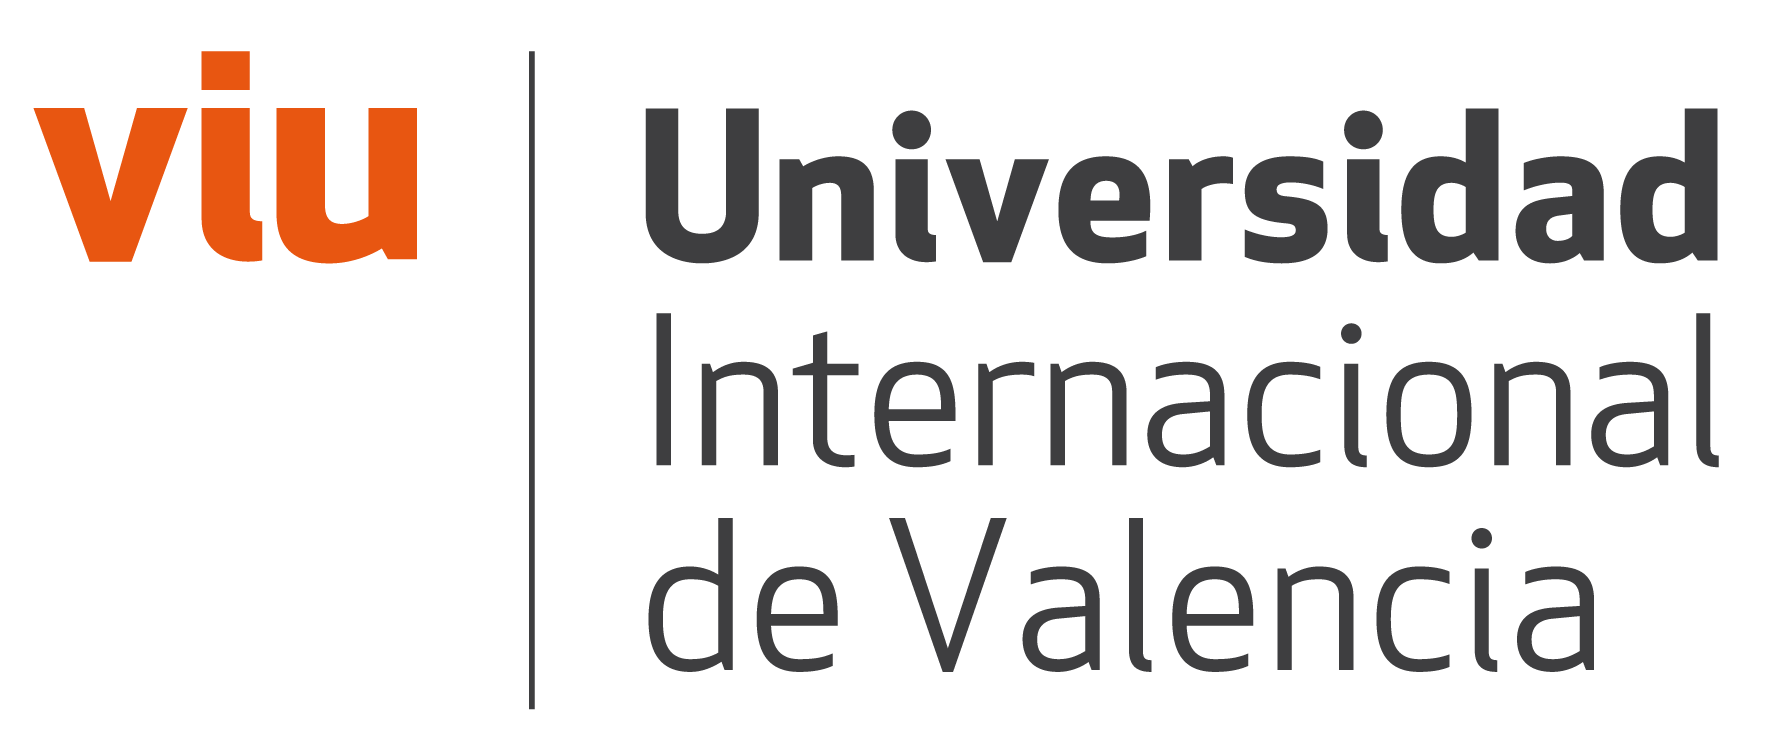

In [ ]:
from IPython.display import Image
Image(filename=BASE_FOLDER+"img/viu_logo.png", width = 400)

# 07MAIR - Redes Neuronales y Deep Learning
## VC07: Más allá


### Profesores: Adrián Colomer
### Autor: Adrián Colomer Granero


# Temas avanzados
- Functional API: Desarrollo de redes neuronales avanzadas
 - Carga de datos desde Google Drive
 - Web scrapping empleando Bing Search API 
- Keras Tuner: Optimización automática de hiperparámetros
- MLflow: Ciclo de vida de un modelo
- Ir más allá

## Functional API
- Hasta ahora hemos desarrollado redes neuronales secuenciales
- Suficiente para muchos contextos, limitante para otros más complejos
 - Inputs independientes, múltiples outputs, ramificaciones internas, skip connections, retroalimentaciones, etc.

#### Ejemplo X input <-> 1 output: Predicción de precio de ropa de segunda mano

- Inputs: metadata marca, tiempo usado (one hot encoded), foto (imagen), descripción (texto). 
- Modelo con tres submodelos (MLP para metadata, RNN para descripción a partir de texto, CNN para imagen)

#### Ejemplo 1 input <-> X output: predicción de año de publicación y estilo de un libro

- Un módulo con dos outputs (clasificadores)

- Desventajas de la alternativa de construir modelos separados:
 - Coste computacional tanto en entrenamiento como en inferencia
 - No se tiene en cuenta toda la información a la vez y analizar la información de manera independiente produce sesgo
 - Se pierden las ventajas de un modelo entrenable end-to-end

# Empleando la functional API: Red MISO CNN+MLP en HOUSE DATASET

- Modelo con dos inputs (atributos y fotos)
- Output: precio de las casas

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

### Mis funciones auxiliares

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

# Filtrar las casas de codigos postales poco populares (menos de 10 casas)
MIN_HOUSES_PER_ZIPCODE = 20
# dimensiones de las imagenes (downsampling)
IMAGE_DIM = (32,32)

# Cargar los atributos del dataset
def load_house_attributes(inputPath):
        # Cargar el dataset con nombres especificados
        cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
        df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)

        # filtrar codigos postales con pocas casas
        zipcodes = df["zipcode"].value_counts().keys().tolist()
        counts = df["zipcode"].value_counts().tolist()

        for (zipcode, count) in zip(zipcodes, counts):
            if count < MIN_HOUSES_PER_ZIPCODE:
                idxs = df[df["zipcode"] == zipcode].index
                df.drop(idxs, inplace=True)

        return df

In [ ]:
# Procesar los atributos
def process_house_attributes(df, train, test):
        # normalizar (valores 0 a 1) atributos continuos
        continuous = ["bedrooms", "bathrooms", "area"]
        cs = MinMaxScaler()
        trainContinuous = cs.fit_transform(train[continuous])
        testContinuous = cs.transform(test[continuous])

        # one-hot encode el codigo postal
        zipBinarizer = LabelBinarizer().fit(df["zipcode"])
        trainCategorical = zipBinarizer.transform(train["zipcode"])
        testCategorical = zipBinarizer.transform(test["zipcode"])

        # unir todos los atributos y dividir dataset
        trainX = np.hstack([trainCategorical, trainContinuous])
        testX = np.hstack([testCategorical, testContinuous])

        return (trainX, testX)

In [ ]:
# Cargar imagenes
def load_house_images(df, inputPath):
        images = []

        # cada linea es un data point
        for i in df.index.values:
            # cargar las cuatro imagenes por casa
            basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
            housePaths = sorted(list(glob.glob(basePath)))
            inputImages = []
            outputImage = np.zeros((IMAGE_DIM[0] * 2, IMAGE_DIM[1] * 2, 3), dtype="uint8")

            # por cada imagen, redimensionar 
            for housePath in housePaths:
                # load the input image, resize it to be 32 32, and then
                # update the list of input images
                image = cv2.imread(housePath)
                image = cv2.resize(image, IMAGE_DIM)
                inputImages.append(image)

            # tile the four input images in the output image such the first
            # image goes in the top-right corner, the second image in the
            # top-left corner, the third image in the bottom-right corner,
            # and the final image in the bottom-left corner
            outputImage[0:IMAGE_DIM[0], 0:IMAGE_DIM[1]] = inputImages[0]
            outputImage[0:IMAGE_DIM[0], IMAGE_DIM[1]:IMAGE_DIM[1]*2] = inputImages[1]
            outputImage[IMAGE_DIM[0]:IMAGE_DIM[0]*2, IMAGE_DIM[1]:IMAGE_DIM[1]*2] = inputImages[2]
            outputImage[IMAGE_DIM[0]:IMAGE_DIM[0]*2, 0:IMAGE_DIM[1]] = inputImages[3]

            # add the tiled image to our set of images the network will be
            # trained on
            images.append(outputImage)

        # return our set of images
        return np.array(images) / 255.0

### Creando la rama MLP

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Activation, concatenate

# Creacion del modelo MLP (para los atributos numericos)
def create_mlp(dim, regress=False):
        model = Sequential()
        model.add(Dense(8, input_dim=dim, activation="relu"))
        model.add(Dense(4, activation="relu"))

        # check to see if the regression node should be added
        if regress:
            model.add(Dense(1, activation="linear"))

        # return our model
        return model

### Creando la rama CNN

In [ ]:
# Crear el modelo CNN
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
        inputShape = (height, width, depth)
        chanDim = -1

        # define the model input
        inputs = Input(shape=inputShape)

        # crear tantas capas como filtros pasados
        for (i, f) in enumerate(filters):
            if i == 0:
                x = inputs

            # CONV => RELU => BN => POOL
            x = Conv2D(f, (3, 3), padding="same")(x)
            x = Activation("relu")(x)
            x = BatchNormalization(axis=chanDim)(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
        
        # Top model
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)

        # Middle output layer
        x = Dense(4)(x)
        x = Activation("relu")(x)

        # Check to see if the regression node should be added
        if regress:
            x = Dense(1, activation="linear")(x)

        model = Model(inputs, x)

        return model

### Importando datos desde Google Drive: House Dataset

In [ ]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# para conectar el notebook con la cuenta de gdrive
from google.colab import drive
drive.mount('/content/drive/')
#!ls "/content/drive/My Drive/"
BASE_FOLDER = '/content/drive/My Drive/07MAIR_0420/'

In [ ]:
# Cargar los atributos numericos
print('Cargando atributoss...')
inputPath = BASE_FOLDER+'resources/Houses-dataset/HousesInfo.txt'
df = load_house_attributes(inputPath)

# Cargar imágenes
print("[INFO] loading house images...")
images = load_house_images(df, BASE_FOLDER+'resources/Houses-dataset')

Cargando atributoss...
[INFO] loading house images...


In [ ]:
images.shape

(384, 64, 64, 3)

### Acondicionamiento de datos

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir imagenes en train y test
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# Normalizar el precio de las casas
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

# Procesar atributos numericos
(trainAttrX, testAttrX) = process_house_attributes(df,trainAttrX, testAttrX)

### Construcción del modelo híbrido

In [ ]:
# Crear los dos modelos (MLP y CNN)
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(IMAGE_DIM[0] * 2, IMAGE_DIM[1]*2, 3, regress=False)

# Unir ambas ramas en una única de salida (concatenarlos)
combinedInput = concatenate([mlp.output, cnn.output])

# Clasificador final tras la concatenacion
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# Construir el modelo final
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

### Compilación y entrenamiento de nuestra red MISO híbrida

In [ ]:
from tensorflow.keras.optimizers import Adam

# utilizamos el optimizador Adam (con learning rate adaptativo)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# entrenar
print("Entrenar el modelo...")
H = model.fit([trainAttrX, trainImagesX], trainY,
        validation_data=([testAttrX, testImagesX], testY),
        epochs=50, batch_size=8)

Entrenar el modelo...
Train on 288 samples, validate on 96 samples
Epoch 1/50
288/288 [==============================] - 4s 12ms/sample - loss: 1058.0105 - val_loss: 697.4843
Epoch 2/50
288/288 [==============================] - 3s 9ms/sample - loss: 702.0007 - val_loss: 220.6218
Epoch 3/50
288/288 [==============================] - 3s 9ms/sample - loss: 619.5501 - val_loss: 224.6528
Epoch 4/50
288/288 [==============================] - 3s 9ms/sample - loss: 446.5802 - val_loss: 241.4039
Epoch 5/50
288/288 [==============================] - 3s 9ms/sample - loss: 343.1163 - val_loss: 213.5732
Epoch 6/50
288/288 [==============================] - 3s 9ms/sample - loss: 307.4464 - val_loss: 143.5633
Epoch 7/50
288/288 [==============================] - 3s 9ms/sample - loss: 216.2664 - val_loss: 168.7331
Epoch 8/50
288/288 [==============================] - 3s 9ms/sample - loss: 237.6755 - val_loss: 181.7929
Epoch 9/50
288/288 [==============================] - 3s 9ms/sample - loss: 171.104

### Evaluando el performance del modelo en test

In [ ]:
# Predicciones en test
print("Predicciones...")
preds = model.predict([testAttrX, testImagesX])

# calcular el error (entre lo predicho y lo esperado)
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# calcular el error medio y su std
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# resultados finales
print("Precio medio: {}. STD: {}".format(df["price"].mean(),df["price"].std()))
print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

Predicciones...
Precio medio: 527956.125. STD: 479979.80059985846
[INFO] mean: 29.02%, std: 33.08


#### Ejercicios

- Calcular la misma métrica para el modelo MLP solamente 
 - ¿Obtenemos mejores o peores resultados sin las imágenes?
- Data augmentation para incrementar los data points (¡pocos!)
- Visualizar los filtros y las activaciones máximas del modelo CNN
 - ¿Se está utilizando de forma efectiva?

### *Keys and Tricks*

- Creación de un dataset propio a partir de imágenes en la red: 
https://docs.microsoft.com/en-us/azure/cognitive-services/bing-image-search/quickstarts/python

- Custom data generator para la lectura de imágenes/datos:
https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c

# Empleando la functional API para el desarrollo de una residual CNN

In [ ]:
# Definition of the CNN with residual connections
NB_Antennas = 16
nn_input  = Input((Nb_Antennas,924,2))
nn_input_shortcut = nn_input

# 1st RESIDUAL BLOCK
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_input)
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same")(nn_output)
nn_input_shortcut = Conv2D(32, (3, 3), padding="same")(nn_input_shortcut)
nn_output = Add()([nn_output, nn_input_shortcut])
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)
nn_output_shortcut = nn_output

# 2nd RESIDUAL BLOCK
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same")(nn_output)
nn_output_shortcut = Conv2D(32, (3, 3), padding="same")(nn_output_shortcut)
nn_output = Add()([nn_output, nn_output_shortcut])
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)

# TOP MODEL
nn_output = Flatten()(nn_output)
nn_output = Dense(128, activation='relu')(nn_output)
nn_output = Dense(128, activation='relu')(nn_output)
nn_output = Dropout(0.25)(nn_output)
nn_output = Dense(128, activation='relu')(nn_output)
nn_output = Dropout(0.5)(nn_output)
nn_output = Dense(3, activation='linear')(nn_output)
nn = Model(inputs=nn_input, outputs=nn_output)
nn.compile(optimizer='Adam', loss='mse', metrics=[dist])
nn.summary()

# Keras Tuner: Optimización de hiperparámetros

Keras Tuner es una librería que ayuda a elegir el conjunto óptimo de hiperparámetros de manera automática. El proceso de seleccionar el conjunto correcto de hiperparámetros para un algoritmo de aprendizaje automático ajuste de hiperparámetros o *hypertuning*.
Existen dos tipos de hiperparámetros:
- **Hiperparámetros de modelo**: Influyen en la selección del modelo, como el número y el ancho de las capas ocultas.

- **Hiperparámetros de algoritmo**: Influyen en la velocidad y la calidad del algoritmo de aprendizaje, p.ejem. la tasa de aprendizaje para el descenso de gradiente estocástico (SGD) y el número de vecinos más cercanos para un clasificador KNN.

### Instalamos Keras Tuner y cargamos dataset fashion MNIST

In [ ]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.2.10
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.2.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.0
blis==0.4.1
bokeh==2.1.1
boto==2.49.0
boto3==1.14.63
botocore==1.17.63
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
certifi==2020.6.20
cffi==1.14.2
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorama==0.4.3
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.3
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
debugpy==1.0.0rc2
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
di

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(img_train, label_train), (img_test, label_test) = fashion_mnist.load_data()
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

4423680/4422102 [==============================] - 0s 0us/step


### Creamos la función que define la topología de red y compila el modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def model_builder(hp):
  model = Sequential()
  model.add(Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(Dense(units = hp_units, activation = 'relu'))
  model.add(Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
  
  return model

### Instanciamos el objeto optimizador

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')  

### Callback para limpiar las salidas de los entrenamientos al finalizar cada paso

In [ ]:
import tensorflow as tf
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

### Llevamos a cabo la optimización de hiperparámetros y nos quedamos con el mejor resultado

In [ ]:
tuner.search(img_train, label_train, epochs = 10, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416 and the optimal learning rate for the optimizer
is 0.001.



# MLflow
Se trata de una plataforma *open source* para la gestión del ciclo de vida de un modelo de *machine learning*. MLflow ofrece cuatro componentes:
- ***MLflow Tracking***: Almacenamiento inteligente y monitorización de experimentos (código, datos, configuración y resultados).
- ***MLflow Projects***: Paquete de código que permite reproducir cualquier formato de código en cualquier plataforma de trabajo.
- ***MLflow Models***: Puesta en marcha de modelo en producción en diversos entornos de servicios.
- ***Model Registry***: Almacena, anota, descubre y gestiona modelos en un repositorio centralizado.

Demos un paseo por la documentación y ejemplos de la librería: https://mlflow.org/